<a href="https://colab.research.google.com/github/xiaorui777/Project/blob/master/Histopathologic_Cancer_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download dataset

In [1]:
!python3 -m pip install kaggle

In [2]:
!pwd

/content


In [3]:
!rm -rf /root/.kaggle
!mkdir /root/.kaggle
!ls -l /root/.kaggle

total 0


In [0]:
# 先把本地的 kaggle.json 上传到 colab 中，再移动到指定文件夹下
!mv kaggle.json /root/.kaggle/

In [5]:
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions download histopathologic-cancer-detection

  0% 0.00/1.33M [00:00<?, ?B/s]
100% 1.33M/1.33M [00:00<00:00, 93.9MB/s]
  0% 0.00/5.10M [00:00<?, ?B/s]
100% 5.10M/5.10M [00:00<00:00, 83.9MB/s]
100% 1.30G/1.30G [00:11<00:00, 95.6MB/s]
100% 1.30G/1.30G [00:11<00:00, 120MB/s] 
100% 4.97G/4.98G [00:40<00:00, 151MB/s]
100% 4.98G/4.98G [00:40<00:00, 132MB/s]


In [0]:
# 创建文件夹
!mkdir train
!mkdir test

In [0]:
# 移动 test.zip 和 train.zip 至指定文件夹
!mv test.zip ./test
!mv train.zip ./train

In [8]:
# 解压
!unzip sample_submission.csv.zip
!unzip train_labels.csv.zip

Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   
Archive:  train_labels.csv.zip
  inflating: train_labels.csv        


In [0]:
# 移动 train_labels.csv 至 train
!mv train_labels.csv ./train

In [10]:
!ls

sample_data	       sample_submission.csv.zip  train
sample_submission.csv  test			  train_labels.csv.zip


In [0]:
!unzip -qq train/train.zip -d /train/

In [0]:
!unzip -qq test/test.zip  -d /test/

In [13]:
import pandas as pd

sample_submission = pd.read_csv('sample_submission.csv')
sample_submission.head()

id  label
0  0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5      0
1  95596b92e5066c5c52466c90b69ff089b39f2737      0
2  248e6738860e2ebcf6258cdc1f32f299e0c76914      0
3  2c35657e312966e9294eac6841726ff3a748febf      0
4  145782eb7caa1c516acbe2eda34d9a3f31c41fd6      0

# Data processing

In [0]:
%matplotlib inline

In [0]:
from typing import List
import logging
from typing import Optional
from functools import partial
from typing import Tuple
from typing import Union


import torch.nn as nn
import numpy as np
import os
import torch
from torch.optim import Adam
from torchvision.models.resnet import BasicBlock
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from PIL import Image
from matplotlib import pyplot as plt
from torchvision.models.resnet import ResNet
from sklearn.metrics import roc_auc_score
from torch import Tensor
from torchvision import transforms
from torch.autograd import Variable

In [0]:
DATA_FOLDER = 'train'
LABELS = f'{DATA_FOLDER}/train_labels.csv'
TRAIN_IMAGES_FOLDER = f'/{DATA_FOLDER}'
USE_GPU = torch.cuda.is_available()

In [0]:
logging.basicConfig(level='INFO')
logger = logging.getLogger()

In [0]:
def read_labels(path_to_file: str) -> pd.DataFrame:
    labels = pd.read_csv(path_to_file)
    return labels


def format_labels_for_dataset(labels: pd.DataFrame) -> np.array:
    return labels['label'].values.reshape(-1, 1)


def format_path_to_images_for_dataset(labels: pd.DataFrame, path: str) -> List:
    return [os.path.join(path, f'{f}.tif') for f in labels['id'].values]


def train_valid_split(df: pd.DataFrame) -> Tuple:
    limit_df = 50000
    df = df.sample(n = df.shape[0])
    df = df.iloc[:limit_df]
    split = 40000
    train = df.iloc[:split]
    valid = df.iloc[:split]
    return train, valid

# Dataset

In [0]:
class MainDataset(Dataset):
    def __init__(self,
                 x_dataset: Dataset,
                 y_dataset: Dataset,
                 x_tfms: Optional = None):
        self.x_dataset = x_dataset
        self.y_dataset = y_dataset
        self.x_tfms = x_tfms

    def __len__(self) -> int:
        return self.x_dataset.__len__()

    def __getitem__(self, index: int) -> Tuple:
        x = self.x_dataset[index]
        y = self.y_dataset[index]
        if self.x_tfms is not None:
            x = self.x_tfms(x)
        return x, y
    
class ImageDataset(Dataset):
    def __init__(self, paths_to_imgs: List):
        self.paths_to_imgs = paths_to_imgs

    def __len__(self) -> int:
        return len(self.paths_to_imgs)

    def __getitem__(self, index: int) -> Image.Image:
        img = Image.open(self.paths_to_imgs[index])
        return img


class LabelDataset(Dataset):
    def __init__(self, labels: List):
        self.labels = labels

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, index: int) -> int:
        return self.labels[index]

In [0]:
labels = read_labels(LABELS)
train, valid = train_valid_split(labels)

train_labels = format_labels_for_dataset(train)
valid_labels = format_labels_for_dataset(valid)

train_images = format_path_to_images_for_dataset(train, TRAIN_IMAGES_FOLDER)
valid_images = format_path_to_images_for_dataset(valid, TRAIN_IMAGES_FOLDER)

train_images_dataset = ImageDataset(train_images)
valid_images_dataset = ImageDataset(valid_images)
train_labels_dataset = LabelDataset(train_labels)
valid_labels_dataset = LabelDataset(valid_labels)

In [67]:
# 共 220024 个数据
labels

id  label
0       f38a6374c348f90b587e046aac6079959adf3835      0
1       c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2       755db6279dae599ebb4d39a9123cce439965282d      0
3       bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4       068aba587a4950175d04c680d38943fd488d6a9d      0
5       acfe80838488fae3c89bd21ade75be5c34e66be7      0
6       a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da      1
7       7f6ccae485af121e0b6ee733022e226ee6b0c65f      1
8       559e55a64c9ba828f700e948f6886f4cea919261      0
9       8eaaa7a400aa79d36c2440a4aa101cc14256cda4      0
10      a106469bbfda4cdc5a9da7ac0152927bf1b4a92d      0
11      c3d660212bf2a11c994e0eadff13770a9927b731      1
12      a1991e73a9b676faddd2bd47c39754b14d1eb923      0
13      08566ce82d4406f464c9c2a3cd014704735db7a9      0
14      94fa32b29cc1c00403176c0795fffa3cfaa0f20e      1
15      f416de7491a31951f79b3cee75b002f4d1bf0162      0
16      a1c001f6b242c72d3066f15ac6eb059ea72d30ba      0
17      0b820b71670c039dd0a51333d1c919f471a9e940      1
18      730431efa2f79927156dcc4382819e9a6cc2c5bb      0
19      d34af1e7500f2f3de41b0e6fdeb2ed245d814590      1
20      4b7a73f1fe1dafe2ffb7d2c0b83107f060b8d693      0
21      5fc468030b7fdb5a0b656a45fa0dde5553dd9064      0
22      4e1e69b64cdeb757178fc5b657b4e5ea07e53935      0
23      464327050ef07bb927f8bfb5c4e4dd5ebd4d3c09      1
24      6961bdcc16f6c1d7db88fc6a7823178288c2a29e      1
25      8e294a0fe82d36c9ae921ef2cc76ed0d0691b90f      0
26      4e491f0beca3cc68b5013cbe726a9b358bf0f668      0
27      ee04141918b4acc1477dd4fd280c64f52a33fcb7      0
28      233bf46a575c1731821073e318c029e5df8b12ff      1
29      e6e31b49681a06c68aca9b64c42a4f002189a081      1
...                                          ...    ...
219995  ea1aa07751fe952fb40f2c9fce965c97adbda52c      1
219996  1101b17ede2115a59e8fac903c0f081a70d29007      0
219997  3e5effc63c4a5b43a1d9f9354775571b7336b8a6      1
219998  748fc31f2a6ef63f7430a320486425701df25cad      1
219999  e5a99c2d5d09239978db4eaa0f55f06c04a04b17      0
220000  5756640b9cadc838a13f2c4e53e19581175eda6e      0
220001  ef25021b450536d7fc41eaf2d0e6d67a079b0bd1      1
220002  9aad90eba3931634e8e5143fec34a0e1aaed6b39      1
220003  bfa9b42ca5cca801730f605d37ff0a7dae477761      0
220004  4dbd43cb1a75fc56515ff138591732aa80822e0f      0
220005  449275b9ab37371753fe63bba30870504c56560b      1
220006  934908c0d6940ce922f7c05eddb0f7eb5cca0097      0
220007  9f0c52d1c2d7c46c60caee232a0a480f4522136c      1
220008  963dc5aa336c1038bf1531c516e57f9ca75f7fab      0
220009  29ee01a126a9c32442fb1bcd0110b37b0f6c2964      1
220010  8a25b1632a1859d7b757e912ca673385b64e1b1d      1
220011  5ba0f128323a89de471938df2ed33d7392a79b03      0
220012  3e24dd48c3a419f4d669cac3cf71e777ba100541      1
220013  1092801a1d1d7cc8e45b1d909c553ea400615d68      0
220014  309210db7f424edbc22b2d13bf2fa27518b18f5c      1
220015  9c0ad1bf43e2fa5e25fac5c8af616c5ae194c187      0
220016  4236e88fb08d16316395f0e71a0a44c4a6fdf794      0
220017  025427fc9743354111cbbc60cab9be094465602b      0
220018  cdf7171a796090072ce521012497c78c9a56cad3      0
220019  1fdacc29221a64e39d5d294d114c9e29da8705ae      0
220020  53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6      0
220021  d4b854fe38b07fe2831ad73892b3cec877689576      1
220022  3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75      0
220023  f129691c13433f66e1e0671ff1fe80944816f5a2      0
220024  a81f84895ddcd522302ddf34be02eb1b3e5af1cb      1

[220025 rows x 2 columns]

# transformers

In [0]:
x_tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [0]:
train_dataset = MainDataset(train_images_dataset, train_labels_dataset, x_tfms)
valid_dataset = MainDataset(valid_images_dataset, valid_labels_dataset, x_tfms)

# Dataloader

In [0]:
shuffle = True
batch_size = 512
num_workers = 0
train_dataloader = DataLoader(train_dataset, 
                              batch_size=batch_size, 
                              shuffle=shuffle, 
                              num_workers=num_workers)
valid_dataloader = DataLoader(valid_dataset, 
                              batch_size=batch_size, 
                              shuffle=False, 
                              num_workers=num_workers)

# Model

In [0]:
# we will create custom resnet with 9 layers so it can process 96x96 images
def to_gpu(tensor):
    return tensor.cuda() if USE_GPU else tensor


def create_resnet9_model(output_dim: int = 1) -> nn.Module:
    model = ResNet(BasicBlock, [1, 1, 1, 1])
    in_features = model.fc.in_features
    model.avgpool = nn.AdaptiveAvgPool2d(1)
    model.fc = nn.Linear(in_features, output_dim)
    model = to_gpu(model)
    return model

In [72]:
resnet9 = create_resnet9_model(output_dim=1)
resnet9

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): R

# Optimizer

In [0]:
lr = 1e-3
optimizer = Adam(resnet9.parameters(), lr=lr)

# Loss

In [0]:
loss = nn.BCEWithLogitsLoss()

# Train

In [0]:
def train_one_epoch(model,
                    train_dataloader,
                    valid_dataloader,
                    loss,
                    optimizer,
                    loss_writer_train,
                    loss_writer_valid,
                    do_step_trigger,
                    valid_loss_trigger,
                    train_loss_trigger,
                    ):
    model.train()
    y_true_train, y_hat_train = [], []
    for iteration, (x, y) in enumerate(train_dataloader):
        x = Variable(T(x), requires_grad=True)
        y = Variable(T(y), requires_grad=True)
        output = model(x)
        y_true_train.append(to_numpy(y))
        y_hat_train.append(to_numpy(output))
        loss_values = loss(output, y)
        loss_values.backward()
        if do_step_trigger(iteration):
            optimizer.step()
            optimizer.zero_grad()
        if train_loss_trigger(iteration):
            auc_writer(y_true_train, y_hat_train, iteration)
            y_true_train, y_hat_train = [], []
        if valid_loss_trigger(iteration):
            y_true, y_hat = predict(model, valid_dataloader)
            auc_writer(y_true, y_hat, iteration)
    return model

# Predict

In [0]:
def predict(model, dataloader):
    model.eval()
    y_true, y_hat = [], []
    with torch.no_grad():
        for x, y in dataloader:
            x = Variable(T(x))
            y = Variable(T(y))
            output = model(x)
            y_true.append(to_numpy(y))
            y_hat.append(to_numpy(output))
    return y_true, y_hat

# Trigger

In [0]:
def iteration_trigger(iteration, every_x_iterations):
    if every_x_iterations == 1:
        return True
    elif iteration > 0 and iteration % every_x_iterations == 0:
        return True
    else:
        return False
    
    
def init_triggers(step=1, valid=10, train=10):
    do_step_trigger = partial(iteration_trigger, every_x_iterations=step)
    valid_loss_trigger = partial(iteration_trigger, every_x_iterations=valid)
    train_loss_trigger = partial(iteration_trigger, every_x_iterations=train)
    return do_step_trigger, valid_loss_trigger, train_loss_trigger

# 精度曲线

In [0]:
def auc_writer(y_true, y_hat, iteration):
    try:
        auc = roc_auc_score(np.vstack(y_true), np.vstack(y_hat))
    except:
        auc = -1
    logger.info(f'iteration: {iteration}, auc: {auc}')

# 定义Tensor

In [0]:
def T(tensor):
    if not torch.is_tensor(tensor):
        tensor = torch.FloatTensor(tensor)
    else:
        tensor = tensor.type(torch.FloatTensor)
    if USE_GPU:
        tensor = to_gpu(tensor)
    return tensor


def to_numpy(tensor: Union[Tensor, Image.Image, np.array]) -> np.ndarray:
    if type(tensor) == np.array or type(tensor) == np.ndarray:
        return np.array(tensor)
    elif type(tensor) == Image.Image:
        return np.array(tensor)
    elif type(tensor) == Tensor:
        return tensor.cpu().detach().numpy()
    else:
        raise ValueError(msg)

In [0]:
loss_writer_train = auc_writer
loss_writer_valid = auc_writer

# backpropagate - every iter
# calculate AUC on valid - every 20 iters 
# AUC on train - every 10 iters
do_step_trigger, valid_loss_trigger, train_loss_trigger = init_triggers(1, 20, 10)

In [81]:
resnet9 = train_one_epoch(
    resnet9,
    train_dataloader,
    valid_dataloader,
    loss,
    optimizer,
    loss_writer_train,
    loss_writer_valid,
    do_step_trigger,
    valid_loss_trigger,
    train_loss_trigger,
)

INFO:root:iteration: 10, auc: 0.8071200953392085
INFO:root:iteration: 20, auc: 0.8842742313460816
INFO:root:iteration: 20, auc: 0.7880219060192701
INFO:root:iteration: 30, auc: 0.7948572265134826
INFO:root:iteration: 40, auc: 0.8702433131966609
INFO:root:iteration: 40, auc: 0.8821102274548094
INFO:root:iteration: 50, auc: 0.8740372707605514
INFO:root:iteration: 60, auc: 0.8814257332535642
INFO:root:iteration: 60, auc: 0.8944506930508715
INFO:root:iteration: 70, auc: 0.8801740208567028


# Prodictions Extraction

In [0]:
y_true, y_hat = predict(resnet9, valid_dataloader)

In [84]:
predictions = pd.DataFrame(
    list(
        zip(
            valid_labels.reshape(-1), 
            np.vstack(y_hat).reshape(-1),
            valid_images
        )
    ), 
     columns=['true', 'pred', 'files'])
predictions.head(10)

true      pred                                              files
0     0 -2.358216  /train/ae47a58bc83b71b8fd7342661ba0c468be97610...
1     0 -2.388144  /train/0696776d2426bda9ce827c5aadfebff1c191853...
2     0 -2.056056  /train/9b01f04c0a2b9973caca7c6f2910570d6bf6310...
3     1 -0.819035  /train/26c9fca73b1974aa4f2634f0ef5ab0e52361541...
4     1  1.019880  /train/6d7dc02160fb94db2ce401e74ee833ded252311...
5     0 -1.520970  /train/7bc375c4001209afbae4e7bacd242838dd215b2...
6     1  2.506579  /train/521f22ffc7665929c91483276391b8866d5f14b...
7     0 -0.951656  /train/2b8fc2fc717960e426b7046460124791b663f76...
8     0 -2.475671  /train/b6cb129ff5b008a391803e59d481c3afbe5263f...
9     1 -1.315816  /train/b82cdc0b693f3c9fb1824ce9dce76e624746908...

# Errors Analysis

In [0]:
max_charts = 60
def implot(files, w=2, h=2, cols=12):
    rows = len(files) / cols + 1
    images = [Image.open(f) for f in files]
    plt.figure(figsize = (cols * w, rows * h))
    plt.tight_layout()
    for chart, img in enumerate(images, 1):
        ax = plt.subplot(rows, cols, chart)
        ax.imshow(np.array(img))
        ax.axis('off')

# FALSE NEGATIVE

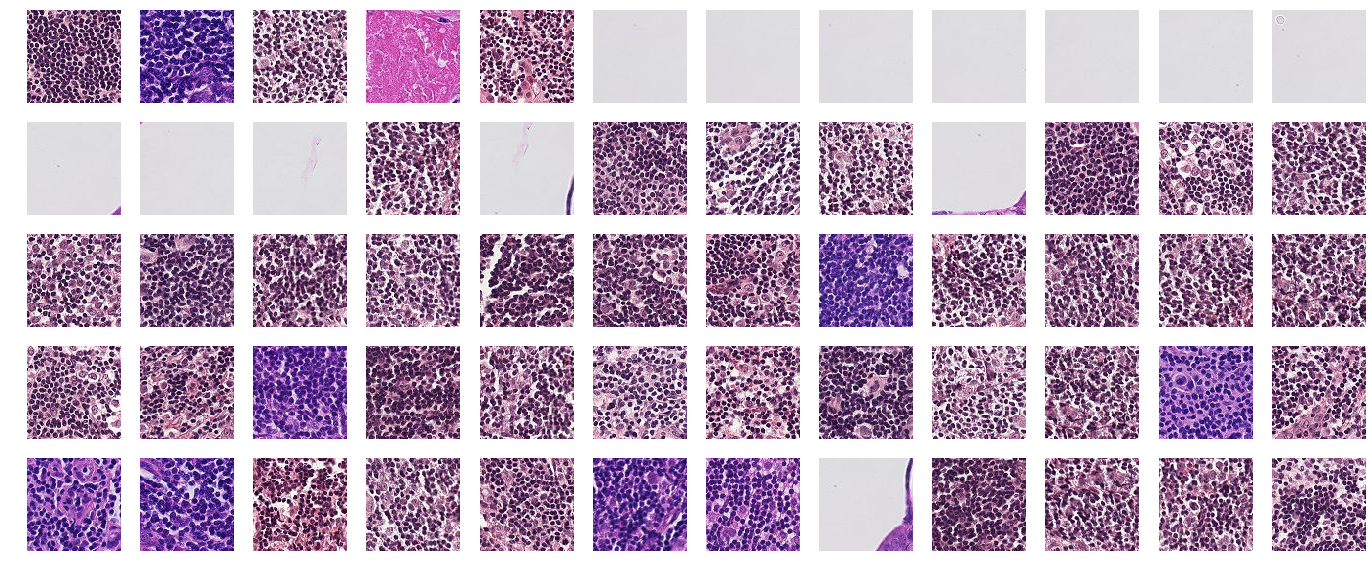

In [86]:
files = predictions[predictions['true']==1].sort_values('pred')['files'].values[:max_charts]
implot(files)

# FALSE POSITIVE

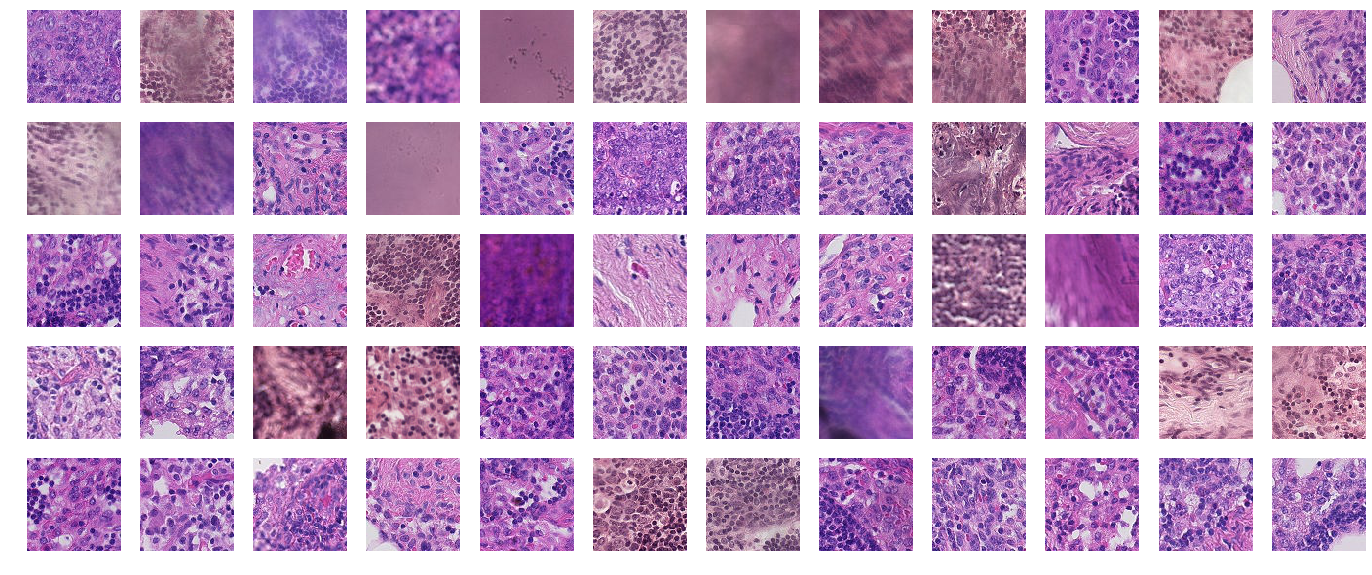

In [87]:
files = predictions[predictions['true']==0].sort_values('pred', ascending=False)['files'].values[:max_charts]
implot(files)

# TRUE POSITIVE

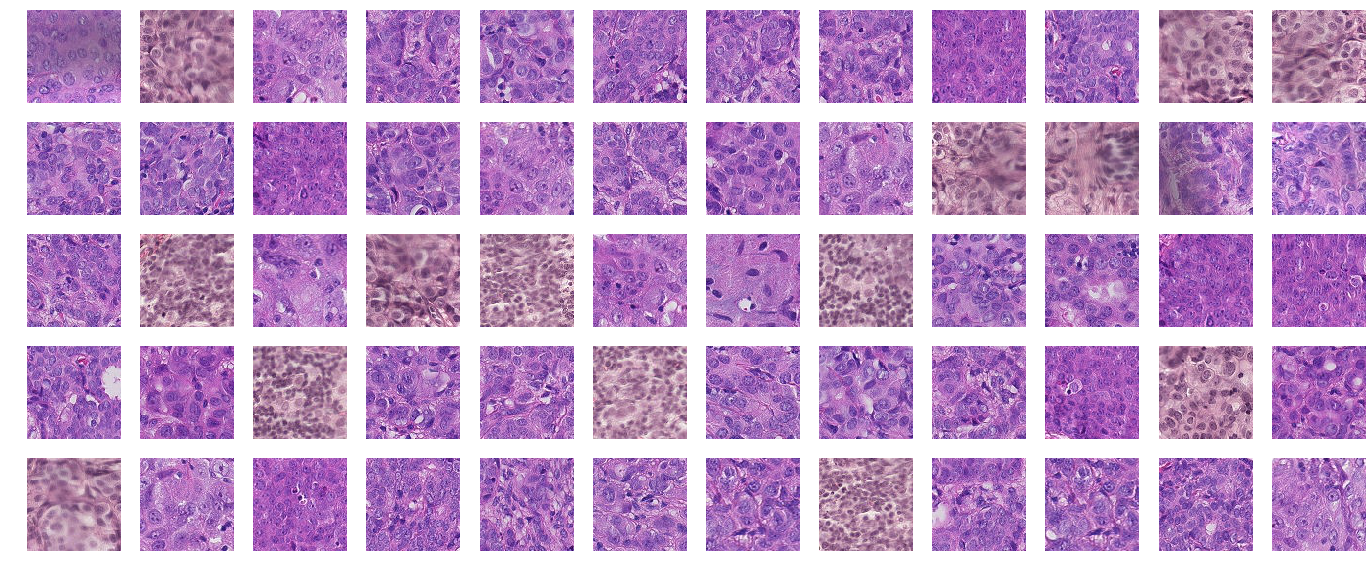

In [88]:
files = predictions[predictions['true']==1].sort_values('pred', ascending=False)['files'].values[:max_charts]
implot(files)

# TRUE NEGATIVE

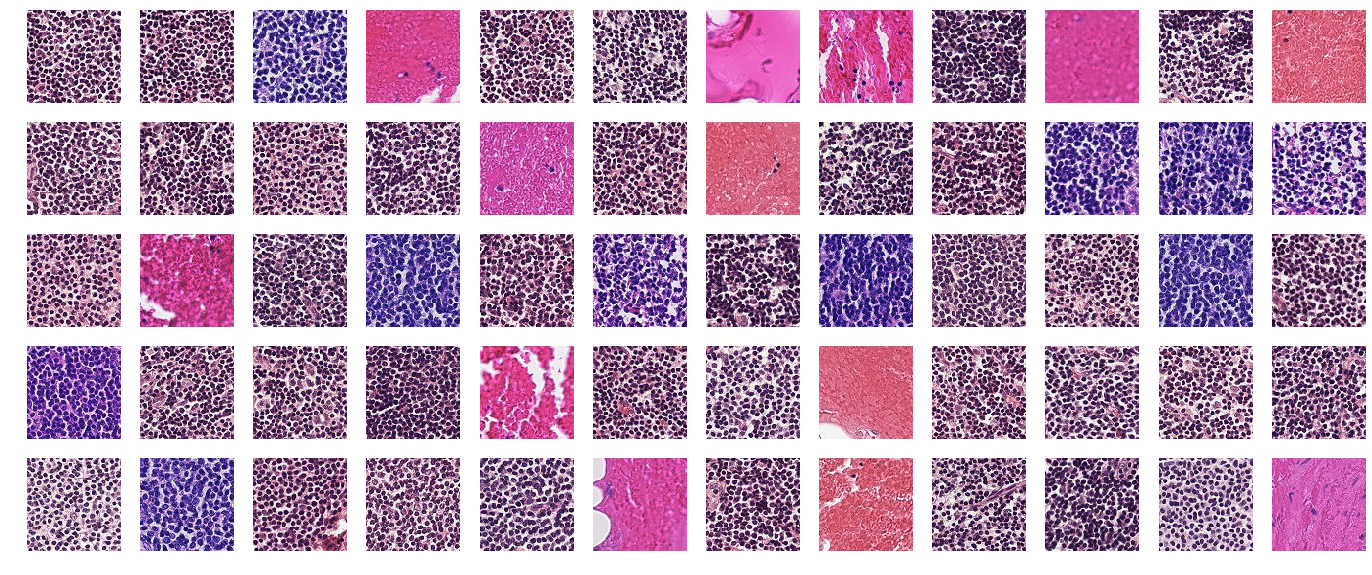

In [89]:
files = predictions[predictions['true']==0].sort_values('pred', ascending=True)['files'].values[:max_charts]
implot(files)